# Finding Growth Opportunities for a Digital Music Store

## Introduction

This project explores sales growth opportunities for a fictional digital music shop. 

My approach involved: 

* __SQL__ to perform data wrangling by using subqueries, multiple joins, aggregate functions and windows functions.
* __Matplotlib__ to create compelling visualisations.
* __Pandas__ including functions for to check the dataset for missing values and duplicates.


## Scenario

The Chinook Record Store is Canadian company based in Calgary which sells digital music, similar to the iTunes store. As a digital music store they sell to customers from around the world. The new manager is looking to adopt data-driven methods into their business strategy and has hired you to analyze their database and make some recommendations. They have the budget to acquire more music for the store and launch a marketing campaign in selected countries. You have been asked to collect insights on the:

* types of best-selling music 
* countries with high sales growth opportunity.

### <font color='grey'>Summary</font> 

* The USA is the top country for sales at the music store with Rock being the best-selling genre for this customer group. 
* Adding more Rock music to the store is likely to be popular amongst these customers and drive sales.

* Customer spending in the Czech Republic, Germany, United Kingdom, India and USA is above average. 
* Of these countries, the Czech Republic and Germany should be considered first for the marketing campaign. As sales in the most recent year decreased in the United Kingdom, India and USA the cause of this should be investigated and remedied.

## Sourcing the Data

The data used in this project comes from the Chinook database, a sample database available at [Github](https://github.com/lerocha/chinook-database).

## Importing Libraries

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%capture
%load_ext sql

## Connecting to the Data

In [3]:
%sql sqlite:///chinook.db

In [4]:
# create connection to sqlite 3
database = 'chinook.db'
con = sql.connect(database)

## Schema

<img src='https://s3.amazonaws.com/dq-content/189/chinook-schema.svg' height= '500' width='500'>

## Overview of the Data

In [5]:
%%sql
SELECT  name,
        type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


* The Chinook database contains __11 tables__ with information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and purchases.

## Loading the Data

Lets begin by viewing a few of the tables to understand what data is available to work with for this analysis.

In [6]:
%%sql
SELECT *
FROM invoice
LIMIT 2

 * sqlite:///chinook.db
Done.


invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.9


In [7]:
%%sql
SELECT *
FROM invoice_line
LIMIT 2

 * sqlite:///chinook.db
Done.


invoice_line_id,invoice_id,track_id,unit_price,quantity
1,1,1158,0.99,1
2,1,1159,0.99,1


In [8]:
%%sql
SELECT *
FROM track
LIMIT 2

 * sqlite:///chinook.db
Done.


track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
2,Balls to the Wall,2,2,1,None,342562,5510424,0.99


<br> Looking at the tables above we can see that invoice, invoice_line and track contain several columns that which we can use for this analysis. A short description of each of these columns is given in the table below.

| Table | Column | Description |
| --- | --- | --- |
| invoice | invoice_id| unique invoice number |
| | customer_id | unique customer number |
| | invoice_date | transaction date |
| | billing_country | country where purchase was made |
| | total | invoice total |
| invoice_line | track_id | unique track number |
| | unit_price | price of track |
| | quantity | number of purchases per track |
| track | album_id | unique album number |
| | genre_id | unique genre number |
| genre | name | genre name |


Next, lets use a JOIN function to combining the relevant columns from above into a single table and create a permanent view containing sales data  called __sales__. This will save us from having to perform the same table join in seperate queries throughout this workbook.

In [9]:
%%sql

-- Create view which contains relevant columns from invoice, invoice_line and track tables.

CREATE VIEW IF NOT EXISTS sales AS
SELECT  i.invoice_id,
        i.customer_id,
        i.invoice_date,
        i.billing_country,
        i.total as invoice_total,
        il.invoice_line_id,
        il.track_id,
        al.artist_id,
        t.album_id,
        t.genre_id,
        il.unit_price,
        il.quantity
FROM invoice as i
    JOIN invoice_line as il
    ON i.invoice_id = il.invoice_id
        JOIN track as t
        ON il.track_id = t.track_id
            JOIN album as al
            ON t.album_id = al.album_id

 * sqlite:///chinook.db
Done.


[]

Each row of the sales view corresponds to the purchase of a single track and contains the track details and transaction information e.g. billing date and country. 

To see what this looks like lets load the sales view.

In [10]:
%%sql 

SELECT *
FROM sales
LIMIT 1

 * sqlite:///chinook.db
Done.


invoice_id,customer_id,invoice_date,billing_country,invoice_total,invoice_line_id,track_id,artist_id,album_id,genre_id,unit_price,quantity
1,18,2017-01-03 00:00:00,USA,15.84,1,1158,88,91,1,0.99,1



## Missing Data and Duplicates

Before performing an analysis it is crucial to determine if there is any erroneous data that may impact our findings. Lets check the data for missing data and duplicates.

In [11]:
#Open sales as dataframe. 

query = ''' SELECT *
            FROM sales'''

df = pd.read_sql(query, con)

rows, columns = df.shape
print('Rows:',rows)

Rows: 4757


* The sales dataset contains __4757__ rows

In [12]:
# Use df.info() and df.describe() to check for missing data.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4757 entries, 0 to 4756
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   invoice_id       4757 non-null   int64  
 1   customer_id      4757 non-null   int64  
 2   invoice_date     4757 non-null   object 
 3   billing_country  4757 non-null   object 
 4   invoice_total    4757 non-null   float64
 5   invoice_line_id  4757 non-null   int64  
 6   track_id         4757 non-null   int64  
 7   artist_id        4757 non-null   int64  
 8   album_id         4757 non-null   int64  
 9   genre_id         4757 non-null   int64  
 10  unit_price       4757 non-null   float64
 11  quantity         4757 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 446.1+ KB


* We can see that all columns contains __4757__ non-null rows.

In [13]:
# Check for duplicate rows

duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [invoice_id, customer_id, invoice_date, billing_country, invoice_total, invoice_line_id, track_id, artist_id, album_id, genre_id, unit_price, quantity]
Index: []


* We returned an empty dataframe meaning there are __no duplicate__ rows. 

Great, the dataset is clean and we are ready to move onto our data analysis.

## Best Selling Music

### <font color='grey'>Date Range</font> 

The invoice_date column contains the transaction date. Since this stored as an object datatype we can use date functions to return a date datatype.

In [14]:
%%sql

SELECT  MIN(DATE(invoice_date)) as first_order,
        MAX(DATE(invoice_date)) as last_order
FROM invoice

 * sqlite:///chinook.db
Done.


first_order,last_order
2017-01-03,2020-12-30


* The database contains data between __2017 - 2020__. 

### <font color='grey'>Total Sales Globally</font> 

We use STRFTIME to extract the year from an object datatype. When combined with an aggregate function we can calculate the total sales per year.

In [15]:
#SQL query
query = '''
SELECT  STRFTIME('%Y', invoice_date) as year,
        ROUND(SUM(unit_price),2) as sum_sales 
FROM sales
GROUP BY 1'''

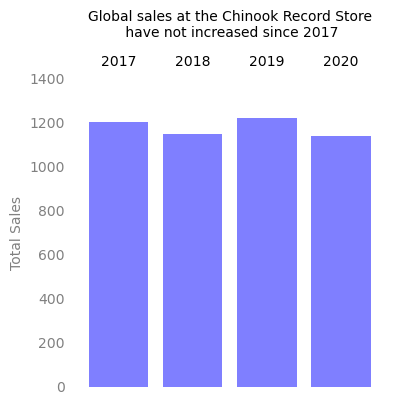

In [16]:
#Read query into pandas dataframe
df = pd.read_sql(query, con)

#Create plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x= df['year'], height= df['sum_sales'], color='blue', alpha=0.5)

#Format plot
ax.set(ylim=(0,1400), ylabel='Total Sales')
for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
ax.yaxis.label.set_color('grey')
ax.tick_params(colors='grey', axis= 'y')
ax.xaxis.tick_top()
ax.tick_params(top= False, left= False)
plt.title('Global sales at the Chinook Record Store\n have not increased since 2017', pad= 30, fontsize= 10)
plt.show()

_Chart showing total sales globally between 2017-2020._

### <font color='grey'>Total Sales by Country</font> 

We can use WITH to store the result of an aggregation into a common table expressions (CTEs) which we can reference in another query. Here we will use this to calculate the percentage of total sales per country.

In [17]:
#SQL query
query = '''
WITH global_total AS (
SELECT  SUM(unit_price) as global_sales
FROM sales
)

SELECT  billing_country as country,
        ROUND(SUM(unit_price),2) as sum_sales,
        ROUND(100.0 * SUM(unit_price) / (SELECT global_sales
                                        FROM global_total),1) as percent_sales
FROM sales
GROUP BY 1
ORDER BY sum_sales ASC
'''

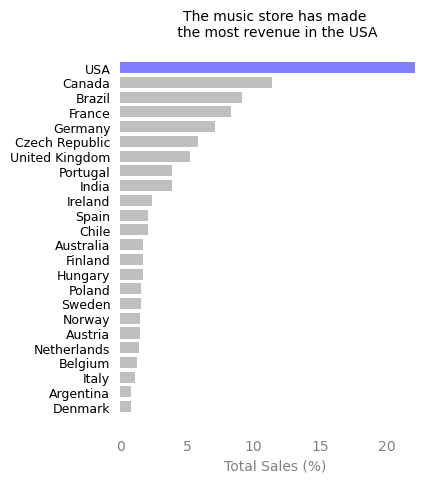

Total countries = 24


In [18]:
#Read query into pandas dataframe
df = pd.read_sql(query, con)

#Create plot
fig, ax = plt.subplots(figsize=(4,5))
max_sales = df['percent_sales'].max()
top_country_bol = df['percent_sales'] == max_sales
color_map = top_country_bol.map({True:'#0000FF', False:'grey'})
ax.barh(y = df['country'], width = df['percent_sales'], height= 0.75, color=color_map, alpha= 0.5)

#Format plot
ax.set(xlabel= 'Total Sales (%)')
for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
ax.xaxis.label.set_color('grey')
ax.tick_params(colors='grey', axis= 'x')
ax.tick_params(labelsize = 9, axis= 'y' )
ax.tick_params(bottom= False, left= False)
plt.title('The music store has made\n the most revenue in the USA', fontsize= 10)
plt.show()

#Calculate total countries
print('Total countries =', len(df))

Top: _Chart showing total sales (%) by country between 2017-2020._
<br/> Bottom: _Total number of countries that the music store sells to._

* The music store sells to __24__ countries of which the most revenue has been made in the __USA__.

### <font color='grey'>Total Customer by Country</font> 

Total sales is likely to correlate with the number of customers for each country. Lets investigate this next.

We can use DISTINCT with an aggregate function to calculate the number of customers per country.

In [19]:
#SQL query
query = '''
SELECT  billing_country as country,
        COUNT(DISTINCT customer_id) as count_customers
FROM sales
GROUP BY 1
ORDER BY 2 ASC'''

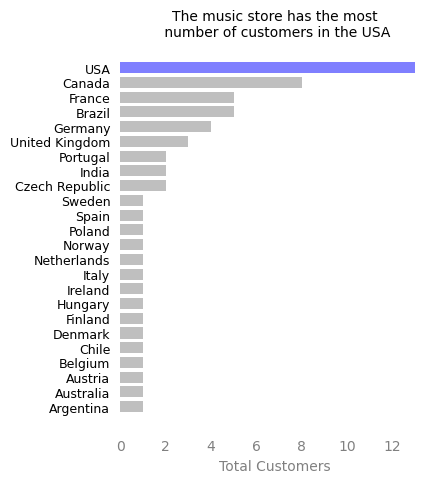

In [20]:
#Read query into pandas dataframe
df = pd.read_sql(query, con)

#Create plot
fig, ax = plt.subplots(figsize=(4,5))
max_customers = df['count_customers'].max()
top_country_bol = df['count_customers'] == max_customers
color_map = top_country_bol.map({True:'#0000FF', False:'grey'})
ax.barh(y = df['country'], width = df['count_customers'], height= 0.75, color=color_map, alpha= 0.5)

#Format plot
ax.set(xlabel= 'Total Customers')
for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
ax.xaxis.label.set_color('grey')
ax.tick_params(colors='grey', axis= 'x')
ax.tick_params(labelsize = 9, axis= 'y' )
ax.tick_params(bottom= False, left= False)
plt.title('The music store has the most\n number of customers in the USA', fontsize= 10)
plt.show()

_Chart showing total number of customers by country between 2017-2020._

* The music store has the most customers in the __USA__.

### <font color='grey'>Top Genres: USA</font> 
 
As the music store is performing well in the USA, lets look at the best selling music categories amongst this customer group.

As we are only interested in sales to the USA we can use WHERE to filter out rows that do not meet the this condition.

In [29]:
query = '''WITH total_tracks_sold AS (
SELECT SUM(quantity)
FROM sales
WHERE billing_country = 'USA'
)

SELECT  t2.name as genre,
        SUM(quantity) as total_sold,
        ROUND(100.0 * SUM(quantity) / (
                                        SELECT *
                                        FROM total_tracks_sold
                                        ),1) as percentage_sold
FROM sales as t1
JOIN genre AS t2
ON t1.genre_id = t2.genre_id
WHERE billing_country = 'USA'
GROUP BY 1
'''

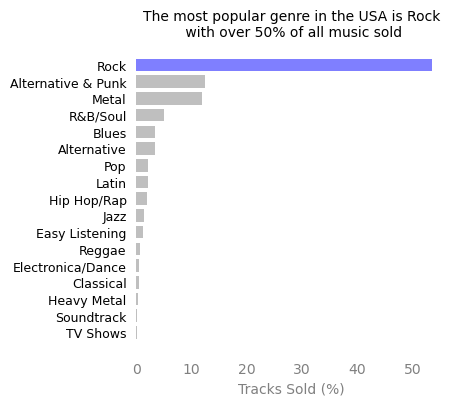

In [30]:
#Read query into pandas dataframe
df = pd.read_sql(query, con)

#Sort df
df = df.sort_values('percentage_sold')

#Create plot
fig, ax = plt.subplots(figsize=(4,4))
max_sales = df['percentage_sold'].max()
top_country_bol = df['percentage_sold'] == max_sales
color_map = top_country_bol.map({True:'#0000FF', False:'grey'})
ax.barh(y = df['genre'], width = df['percentage_sold'], height= 0.75, color=color_map, alpha= 0.5)

#Format plot
ax.set(xlabel= 'Tracks Sold (%)')
for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
ax.xaxis.label.set_color('grey')
ax.tick_params(colors='grey', axis= 'x')
ax.tick_params(labelsize = 9, axis= 'y' )
ax.tick_params(bottom= False, left= False)
plt.title('The most popular genre in the USA is Rock\n with over 50% of all music sold', fontsize= 10)
plt.show()

_Chart showing the Top 10 Genres in the USA between 2017-2020._

* The most popular genre in the USA is __Rock__.

## Countries with Growth Opportunity.

So far we have looked for the top country for sales and made some insights into the music preferences of this customer group.

The music store is looking to boost sales in in other countries and plans to launch a marketing campaign in a select number of countries. 

To provide a recommendation lets calculate the following sales metrics:
* __Average sales per customer__
* __Average sales per order__

Here we will employ CASE. Since a number of countries only have one customer lets group these countries into 'Other' and put them to the bottom of the visualisations.

### <font color='grey'>Sales Per Customer</font> 

In [23]:
query = '''
WITH group_countries_by_customers AS (
SELECT  country,
        COUNT(customer_id) as count_customers
FROM customer
GROUP BY country
),

country_or_other AS (
SELECT  country, 
        CASE 
            WHEN count_customers = 1 THEN 'Other'
            ELSE country
        END AS country_group
FROM group_countries_by_customers
),

modified_invoice AS (
SELECT  i.customer_id, 
        i.invoice_id, 
        i.total,
        co.country_group, 
        CASE
            WHEN co.country_group = 'Other' THEN 1
        END AS sort
FROM invoice as i
    JOIN country_or_other as co
    ON co.country = i.billing_country
)

SELECT  country_group,
        ROUND(SUM(total) / COUNT(DISTINCT customer_id),2) as avg_sales_per_customer,
        ROUND(AVG(total),2) as avg_order_value
FROM modified_invoice
GROUP BY 1;'''

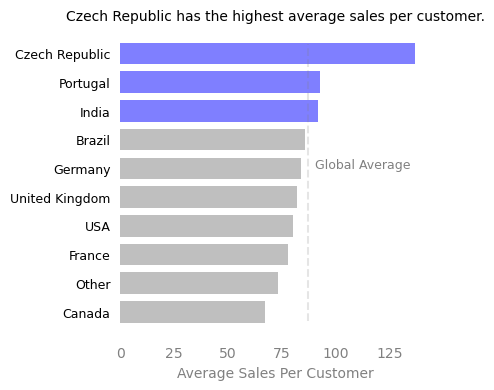

In [24]:
#Read query into pandas dataframe
df = pd.read_sql(query, con)

#Calculate global average
global_average = df['avg_sales_per_customer'].mean()

#Sort by avg sales per customer
df = df.sort_values('avg_sales_per_customer')

#Create plots
fig, ax = plt.subplots(figsize=(4,4))
avg_sales = df['avg_sales_per_customer'].mean()
top_country_bol = df['avg_sales_per_customer'] > avg_sales
color_map = top_country_bol.map({True:'#0000FF', False:'grey'})
ax.barh(y= df['country_group'], width= df['avg_sales_per_customer'], height= 0.75, color=color_map, alpha= 0.5)

#Format plots
ax.set(xlabel= 'Average Sales Per Customer')
for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
ax.xaxis.label.set_color('grey')
ax.tick_params(colors='grey', axis= 'x')
ax.tick_params(labelsize = 9, axis= 'y' )
ax.tick_params(bottom= False, left= False)
ax.axvline(x= global_average, ymin= 0.05, ymax= 0.95, alpha = 0.2, color = 'grey', linestyle = '--')
plt.text(s= 'Global Average', x= 90, y= 5, fontsize = 9, color = 'grey')
plt.title('Czech Republic has the highest average sales per customer.', fontsize = 10)

plt.show()

_Chart showing average sales per customer by country between 2017-2020. Countries above the global average have been highlighted._

* The __Czech Republic__ has the highest average sales per customer. Portugal and India also exceed the global average.

### <font color='grey'>Sales Per Order</font> 

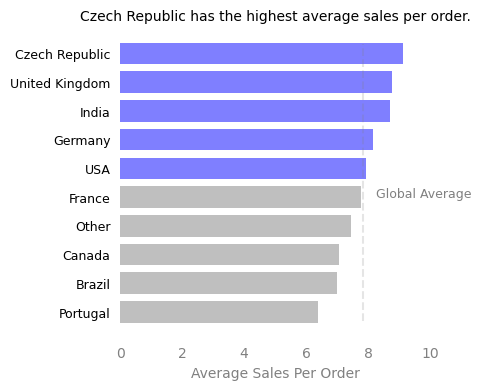

In [25]:
#Sort by avg sales per customer
df = df.sort_values('avg_order_value')

#Calculate global average
global_average = df['avg_order_value'].mean()

#Create plots
fig, ax = plt.subplots(figsize=(4,4))
avg_order = df['avg_order_value'].mean()
top_country_bol = df['avg_order_value'] > avg_order
color_map = top_country_bol.map({True:'#0000FF', False:'grey'})
ax.barh(y= df['country_group'], width= df['avg_order_value'], height= 0.75, color=color_map, alpha= 0.5)

#Format plots
ax.set(xlabel= 'Average Sales Per Order', xlim = (0,10))
for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
ax.xaxis.label.set_color('grey')
ax.tick_params(colors='grey', axis= 'x')
ax.tick_params(labelsize = 9, axis= 'y' )
ax.tick_params(bottom= False, left= False)
ax.axvline(x= global_average, ymin= 0.05, ymax= 0.95, alpha = 0.2, color = 'grey', linestyle = '--')
plt.text(s= 'Global Average', x= 8.25, y= 4, fontsize = 9, color = 'grey')
plt.title('Czech Republic has the highest average sales per order.', fontsize = 10)
plt.show()

_Chart showing average sales per order by country between 2017-2020. Countries above the global average have been highlighted._

* The __Czech Republic__ has the highest average sales per order. The United Kingdom, India, Germany and the USA also exceed the global average.

### <font color='grey'>Sales Growth: Selected Countries</font> 

We've identified that customer spending is above average in Czech Republic, United Kingdom, India, Germany, USA.

Next lets look at the sales growth trends between 2017-2020 by calculating the percentage change in sales per order for each year.

To do this we can use windows functions to access data from the row previous to the current row.

In [27]:
query = '''
WITH group_by AS (
SELECT  billing_country as country,
        STRFTIME('%Y', invoice_date) as year,
        ROUND(SUM(total),2) as sales,    
        COUNT(invoice_id) as orders,
        ROUND((SUM(total)/COUNT(invoice_id)),2) as sales_per_order
FROM invoice
GROUP BY 1, 2
),

lag AS (
SELECT *,
        LAG(sales_per_order) OVER (
                             PARTITION BY country
                             ORDER BY year) as previous_sales_per_order
FROM group_by
),

change_in as (
SELECT country,
        year,
        100.0* (sales_per_order - previous_sales_per_order)/previous_sales_per_order as change_in_sales_per_order
FROM lag
WHERE year IS NOT '2017'
)

SELECT *
FROM change_in
WHERE country = 'Czech Republic' OR country = 'United Kingdom' OR country = 'India' OR country = 'Germany' OR country = 'USA'
'''

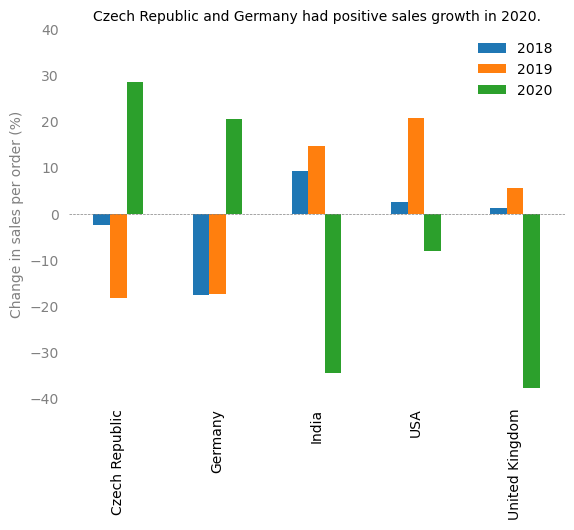

In [28]:
#Read query into pandas dataframe
df = pd.read_sql(query, con)

#Create pivot table 
pt = pd.pivot_table(data = df, values = 'change_in_sales_per_order', index = 'year', columns= 'country')

#Create plots
ax = pt.T.plot(kind='bar', xlabel = '', ylabel = 'Change in sales per order (%)', ylim = (-40,40))

#Format plots

for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
ax.xaxis.label.set_color('grey')
ax.tick_params(colors='grey', axis= 'y')
ax.tick_params(bottom= False, left= False)
ax.yaxis.label.set_color('grey')
plt.title('Czech Republic and Germany had positive sales growth in 2020.', fontsize = 10)
ax.axhline(y=0, linewidth = 0.5, color = 'grey', linestyle = '--')
plt.legend(frameon=False)
plt.show()

*Chart showing percentage change in sales per order over time for selected countries.*

* Sales increased in the __Czech Republic__ and __Germany__ in 2020. Sales decreased in the USA, India and the United Kingdom.

## Conclusions

It was found that:

Between 2017 - 2020
* Globally, there has been little to no sales growth since 2017.
* The music store sells to customers in 24 countries.
* The __USA__ has generated the most revenue and also has the highest number of customers.
* In the USA the most popular music genre is __Rock__.

* The __Czech Republic__ had the highest average sales per customer. Portugal and India also exceed the global average.
* The __Czech Republic__ had the highest average sales per order. The United Kingdom, India, Germany and the USA also exceed the global average.

In 2020
* Sales increased in the __Czech Republic__ and __Germany__ in 2020. Sales decreased in the USA, India and the United Kingdom.

## Recommendations

__1st__

An analysis of top genres in the USA found Rock music to be the best-selling genre. As the USA is the top country for sales at the music store we can recommend adding more music from this category is likely to be popular amongst these customers.

__2nd__

An analysis of customer spending between 2017-2020 revealed that the Czech Republic and Germany to be above average. Furthermore, the sales in 2020 increased significantly from the previous year. Therefore, these countries have been identified to be high sales growth countries. However, due to low sample size involved in this analysis we recommend surveying additional customers and collecting more data before launching the marketing campaign

__3rd__

An analysis of customer spending between 2017-2020 revealed that the United Kingdom, India and USA were also above average. However, it was also shown that sales decreased in 2020 compared to the previous year. Thus, we recommend these customers are also survey to highlight and remedy any issues related to customer experience before marketing to these countries.